In [421]:
from transformers import BertTokenizer, TFBertModel
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

import unicodedata
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re

from sklearn import preprocessing

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [535]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [536]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#model = TFBertModel.from_pretrained("bert-base-cased")
#text = "Replace me by any text you'd like."
#encoded_input = tokenizer(text, return_tensors='tf')
#output = model(encoded_input)

#model_name="bert-base-uncased"
model_name="bert-base-cased"

tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

max_length = 512

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /Users/kerry/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /Users/kerry/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /Users/kerry/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da

In [537]:
#uploaded = files.upload()
#data_df = pd.read_csv(io.BytesIO(uploaded['msds543_chatbotdata.csv']))
#varieties_df = pd.read_csv(io.BytesIO(uploaded['wine_list.csv']))
#blogOsVinhos = pd.read_excel("BlogOsVinhos.xlsx")

FILE_PATH = "../../master-thesis/data/"

data_df = pd.read_csv(f"{FILE_PATH}/msds543_chatbotdata.csv")
varieties_df = pd.read_csv(f"{FILE_PATH}/wine_list.csv")
blogOsVinhos = pd.read_excel(f"{FILE_PATH}/BlogOsVinhos.xlsx")
blogOsVinhos.rename(columns={"Name": "name", "Region": "region", "Producer": "brand"
                            }, inplace=True)

In [538]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"['my', 'favorite', 'white', 'wine', 'this', 'f...",1,yes
1,1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,True,"Tart, not sweet...very refreshing and delicious!",5.0,"Yum!! Tart, not sweet...very refreshing and de...","['yum', 'tart', 'sweetvery', 'refreshing', 'de...",1,yes
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"['a', 'new', 'favorite', 'i', 'given', 'wine',...",1,yes
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","['bold', 'flavorful', 'aromatic', 'delicious',...",1,yes
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","['yum', 'plus', 'environmentally', 'friendly',...",1,yes


In [539]:
type(data_df.processed_text.iloc[0])

str

In [540]:
# fixing conversion issue
data_df['processed_text'] = data_df.processed_text.apply(lambda xyz: eval(xyz))

In [541]:
type(data_df.processed_text.iloc[0])

list

In [542]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"[my, favorite, white, wine, this, fantastic, w...",1,yes
1,1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,True,"Tart, not sweet...very refreshing and delicious!",5.0,"Yum!! Tart, not sweet...very refreshing and de...","[yum, tart, sweetvery, refreshing, delicious]",1,yes
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"[a, new, favorite, i, given, wine, delightful,...",1,yes
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","[bold, flavorful, aromatic, delicious, this, p...",1,yes
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","[yum, plus, environmentally, friendly, 4, 750m...",1,yes


In [543]:
blogOsVinhos.tail()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link
2988,Muxagat 2005,DOC Douro,2005,Red,"Touriga Nacional, Tinta Roriz e Touriga Franca",13.0,"Muxagat Vinhos, Lda",10.0,12.5,Mateus Nicolau de Almeida,16.5,Dezembro 2009,Apresenta uma cor avioletada intensa e um nari...,-,https://osvinhos.blogspot.pt/2010/01/1195-muxa...
2989,Muxagat 2014,DOC Douro,2014,White,"Rabigato, Gouveio, Síria e Arinto",13.5,"Muxagat Vinhos, Lda",10.0,12.5,Mateus Nicolau de Almeida,15.5,Fevereiro 2017,Cor amarela pálida e nariz muito mineral e veg...,As uvas deste vinho são provenientes de várias...,https://osvinhos.blogspot.pt/2017/10/4546-muxa...
2990,Muxagat Tinta Barroca 2010,DOC Douro,2010,Red,Tinta Barroca,13.0,"Muxagat Vinhos, Lda",7.5,10.0,Mateus Nicolau de Almeida,15.5,Dezembro 2012,Cor rubi de média concentração e auréola de to...,-,https://osvinhos.blogspot.pt/2012/10/2394-muxa...
2991,Myrtus Reserva Arinto 2007,DOC Estremadura,2007,White,Arinto,13.5,Quinta da Murta,7.5,10.0,Nuno Cancela de Abreu e Hugo Mendes,15.5,Janeiro 2009,"Cor pálida e ligeiramente esverdeada, no nariz...",-,https://osvinhos.blogspot.pt/2010/04/1277-myrt...
2992,Mythos 2008,DOC Tejo,2008,Red,"Touriga Nacional, Touriga Franca e Cabernet Sa...",14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...


In [544]:
def strip_accents(STR):
    return ''.join(c for c in unicodedata.normalize('NFD', STR)
                   if unicodedata.category(c) != 'Mn')

def clean_doc(doc): 
    """
    Given a string doc,
    this function cleans the doc
    of . . .
    non-ascii chars
    punctuation
    anything other than lower case words
    non-alphabetic tokens
    stop words
    tokens shorter than length 3
    stem, lemma are also options
    returns the list of tokens.
    """
    doc = doc.lower()
    doc = doc.replace('cabernet sauvignon', 'cabernet_sauvignon')
    doc = doc.replace('pinot noir', 'pinot_noir')
    doc = doc.replace('pinot grigio', 'pinot_grigio')
    doc = doc.replace('red blend', 'red_blend')
    doc = doc.replace("touriga nacional", "touriga_nacional")
    doc = doc.replace("tinta roriz", "tinta_roriz")
    doc = doc.replace("touriga franca", "touriga_franca")
    doc = doc.replace("cbernet", "cabernet")
    doc = doc.replace("cabernet franc", "cabernet_franc")

    doc = re.sub(r'[^\x00-\x7F]', '', str(doc)) # removes any remaining non-ascii chars
    
    # turn 'cabernet sauvignon' into cabernet_sauvignon
    
    tokens = doc.split(" ") # set the tone
    
    # punctuation situation
    sub_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [str(sub_punc.sub('', w)) for w in tokens]
    
    # alpha
    tokens = [word for word in tokens if word.isalpha()]
    
    # shorties
    tokens = [word for word in tokens if len(word) > 3]
    
    # capitalization
    tokens = [word.lower() for word in tokens]
    
    # stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    # lemma
    return tokens # tokens is a list

In [545]:
blogOsVinhos.JudgeNotes.isnull().sum()

1

In [546]:
blogOsVinhos.Castes.isnull().sum()

4

In [547]:
blogOsVinhos.head()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link
0,.Beb 2007,Regional Alentejo,2007,Rosé,"Cabernet Sauvignon, Syrah e Touriga Nacional",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,Dezembro 2008,Cor vermelha brilhante e aromas iniciais domin...,Tem uma cor atraente e um aroma intenso a frut...,https://osvinhos.blogspot.pt/2010/03/1232-beb-...
1,.Beb 2009,Regional Alentejo,2009,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,Novembro 2012,"Cor avermelhada e nariz muito aromático, onde ...",A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2013/08/2803-beb-...
2,.Beb 2010,Regional Alentejo,2010,Red,"Cabernet Sauvignon, Syrah, Alicante Bouschet e...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,Agosto 2013,Apresenta uma cor rubi agradavelmente concentr...,A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2014/01/2988-beb-...
3,.Beb 2011,Regional Alentejo,2011,White,"Arinto, Roupeiro e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço e Susana Esteban,15.5,Setembro 2012,Cor amarela brilhante e nariz delicadamente ma...,Associámos uma vinha muito velha de Roupeiro c...,https://osvinhos.blogspot.pt/2013/09/2820-beb-...
4,.Beb 2012,Regional Alentejo,2012,White,"Encruzado, Verdelho e Viognier",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço e Susana Esteban,16.0,Julho 2014,Apresenta uma cor amarela ligeiramente pálida ...,Associámos a estrutura e complexidade do Encru...,https://osvinhos.blogspot.pt/2015/06/3639-beb-...


In [548]:
blogOsVinhos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               2993 non-null   object 
 1   region             2989 non-null   object 
 2   Year               2993 non-null   int64  
 3   Color              2993 non-null   object 
 4   Castes             2989 non-null   object 
 5   AlcoholPercentage  2993 non-null   float64
 6   brand              2993 non-null   object 
 7   MinimunPrice       2993 non-null   float64
 8   MaximumPrice       2993 non-null   float64
 9   Judge              2993 non-null   object 
 10  JudgeRating        2993 non-null   float64
 11  Date               2970 non-null   object 
 12  JudgeNotes         2992 non-null   object 
 13  Label              2992 non-null   object 
 14  Link               2993 non-null   object 
dtypes: float64(4), int64(1), object(10)
memory usage: 350.9+ KB


In [549]:
blogOsVinhos.shape

(2993, 15)

In [550]:
blogOsVinhos = blogOsVinhos[blogOsVinhos['Castes'].notna()]
blogOsVinhos = blogOsVinhos[blogOsVinhos['JudgeNotes'].notna()]

In [551]:
blogOsVinhos.shape

(2988, 15)

In [552]:
blogOsVinhos['Castes'] = blogOsVinhos['Castes'].apply(clean_doc)
blogOsVinhos['processed_text'] = blogOsVinhos['JudgeNotes'].apply(clean_doc)

In [553]:
blogOsVinhos.head()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link,processed_text
0,.Beb 2007,Regional Alentejo,2007,Rosé,"[cabernetsauvignon, syrah, touriganacional]",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço,15.5,Dezembro 2008,Cor vermelha brilhante e aromas iniciais domin...,Tem uma cor atraente e um aroma intenso a frut...,https://osvinhos.blogspot.pt/2010/03/1232-beb-...,"[vermelha, brilhante, aromas, iniciais, domina..."
1,.Beb 2009,Regional Alentejo,2009,Red,"[cabernetsauvignon, syrah, alicante, bouschet,...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Susana Esteban,16.0,Novembro 2012,"Cor avermelhada e nariz muito aromático, onde ...",A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2013/08/2803-beb-...,"[avermelhada, nariz, muito, aromtico, onde, no..."
2,.Beb 2010,Regional Alentejo,2010,Red,"[cabernetsauvignon, syrah, alicante, bouschet,...",14.0,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço,16.0,Agosto 2013,Apresenta uma cor rubi agradavelmente concentr...,A escolha criteriosa das melhores parcelas das...,https://osvinhos.blogspot.pt/2014/01/2988-beb-...,"[apresenta, rubi, agradavelmente, concentrada,..."
3,.Beb 2011,Regional Alentejo,2011,White,"[arinto, roupeiro, viognier]",13.5,Tiago Mateus Cabaço e Cabaço,7.5,10.0,Tiago Cabaço e Susana Esteban,15.5,Setembro 2012,Cor amarela brilhante e nariz delicadamente ma...,Associámos uma vinha muito velha de Roupeiro c...,https://osvinhos.blogspot.pt/2013/09/2820-beb-...,"[amarela, brilhante, nariz, delicadamente, mar..."
4,.Beb 2012,Regional Alentejo,2012,White,"[encruzado, verdelho, viognier]",13.5,Tiago Mateus Cabaço e Cabaço,4.0,7.5,Tiago Cabaço e Susana Esteban,16.0,Julho 2014,Apresenta uma cor amarela ligeiramente pálida ...,Associámos a estrutura e complexidade do Encru...,https://osvinhos.blogspot.pt/2015/06/3639-beb-...,"[apresenta, amarela, ligeiramente, plida, nari..."


In [554]:
blogOsVinhos.tail()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link,processed_text
2988,Muxagat 2005,DOC Douro,2005,Red,"[touriganacional, tintaroriz, tourigafranca]",13.0,"Muxagat Vinhos, Lda",10.0,12.5,Mateus Nicolau de Almeida,16.5,Dezembro 2009,Apresenta uma cor avioletada intensa e um nari...,-,https://osvinhos.blogspot.pt/2010/01/1195-muxa...,"[apresenta, avioletada, intensa, nariz, frutad..."
2989,Muxagat 2014,DOC Douro,2014,White,"[rabigato, gouveio, sria, arinto]",13.5,"Muxagat Vinhos, Lda",10.0,12.5,Mateus Nicolau de Almeida,15.5,Fevereiro 2017,Cor amarela pálida e nariz muito mineral e veg...,As uvas deste vinho são provenientes de várias...,https://osvinhos.blogspot.pt/2017/10/4546-muxa...,"[amarela, plida, nariz, muito, mineral, vegeta..."
2990,Muxagat Tinta Barroca 2010,DOC Douro,2010,Red,"[tinta, barroca]",13.0,"Muxagat Vinhos, Lda",7.5,10.0,Mateus Nicolau de Almeida,15.5,Dezembro 2012,Cor rubi de média concentração e auréola de to...,-,https://osvinhos.blogspot.pt/2012/10/2394-muxa...,"[rubi, mdia, concentrao, aurola, tonalidade, a..."
2991,Myrtus Reserva Arinto 2007,DOC Estremadura,2007,White,[arinto],13.5,Quinta da Murta,7.5,10.0,Nuno Cancela de Abreu e Hugo Mendes,15.5,Janeiro 2009,"Cor pálida e ligeiramente esverdeada, no nariz...",-,https://osvinhos.blogspot.pt/2010/04/1277-myrt...,"[plida, ligeiramente, esverdeada, nariz, sobre..."
2992,Mythos 2008,DOC Tejo,2008,Red,"[touriganacional, tourigafranca, cabernetsauvi...",14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la..."


In [555]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"[my, favorite, white, wine, this, fantastic, w...",1,yes
1,1,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,True,"Tart, not sweet...very refreshing and delicious!",5.0,"Yum!! Tart, not sweet...very refreshing and de...","[yum, tart, sweetvery, refreshing, delicious]",1,yes
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"[a, new, favorite, i, given, wine, delightful,...",1,yes
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","[bold, flavorful, aromatic, delicious, this, p...",1,yes
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","[yum, plus, environmentally, friendly, 4, 750m...",1,yes


In [556]:
blogOsVinhos.iloc[0].processed_text

['vermelha',
 'brilhante',
 'aromas',
 'iniciais',
 'dominados',
 'apimentado',
 'aliado',
 'notas',
 'frutadas',
 'foram',
 'conjunto',
 'interessante',
 'boca',
 'presena',
 'agradvel',
 'fresco',
 'delicado',
 'sempre',
 'dominado',
 'notas',
 'frutadas',
 'final',
 'mdio',
 'comprimento',
 'persistente',
 'sabor']

In [557]:
blogOsVinhos = blogOsVinhos.explode('Castes')

In [558]:
blogOsVinhos.tail()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link,processed_text
2990,Muxagat Tinta Barroca 2010,DOC Douro,2010,Red,barroca,13.0,"Muxagat Vinhos, Lda",7.5,10.0,Mateus Nicolau de Almeida,15.5,Dezembro 2012,Cor rubi de média concentração e auréola de to...,-,https://osvinhos.blogspot.pt/2012/10/2394-muxa...,"[rubi, mdia, concentrao, aurola, tonalidade, a..."
2991,Myrtus Reserva Arinto 2007,DOC Estremadura,2007,White,arinto,13.5,Quinta da Murta,7.5,10.0,Nuno Cancela de Abreu e Hugo Mendes,15.5,Janeiro 2009,"Cor pálida e ligeiramente esverdeada, no nariz...",-,https://osvinhos.blogspot.pt/2010/04/1277-myrt...,"[plida, ligeiramente, esverdeada, nariz, sobre..."
2992,Mythos 2008,DOC Tejo,2008,Red,touriganacional,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la..."
2992,Mythos 2008,DOC Tejo,2008,Red,tourigafranca,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la..."
2992,Mythos 2008,DOC Tejo,2008,Red,cabernetsauvignon,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la..."


In [559]:
blogOsVinhos['variety'] = blogOsVinhos['Castes'] 

In [560]:
blogOsVinhos.tail()

,name,region,Year,Color,Castes,AlcoholPercentage,brand,MinimunPrice,MaximumPrice,Judge,JudgeRating,Date,JudgeNotes,Label,Link,processed_text,variety
2990,Muxagat Tinta Barroca 2010,DOC Douro,2010,Red,barroca,13.0,"Muxagat Vinhos, Lda",7.5,10.0,Mateus Nicolau de Almeida,15.5,Dezembro 2012,Cor rubi de média concentração e auréola de to...,-,https://osvinhos.blogspot.pt/2012/10/2394-muxa...,"[rubi, mdia, concentrao, aurola, tonalidade, a...",barroca
2991,Myrtus Reserva Arinto 2007,DOC Estremadura,2007,White,arinto,13.5,Quinta da Murta,7.5,10.0,Nuno Cancela de Abreu e Hugo Mendes,15.5,Janeiro 2009,"Cor pálida e ligeiramente esverdeada, no nariz...",-,https://osvinhos.blogspot.pt/2010/04/1277-myrt...,"[plida, ligeiramente, esverdeada, nariz, sobre...",arinto
2992,Mythos 2008,DOC Tejo,2008,Red,touriganacional,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la...",touriganacional
2992,Mythos 2008,DOC Tejo,2008,Red,tourigafranca,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la...",tourigafranca
2992,Mythos 2008,DOC Tejo,2008,Red,cabernetsauvignon,14.0,Quinta do Casal da Coelheira,15.0,20.0,Nuno Falcão Rodrigues,16.5,Junho 2014,Cor rubi intensa e muito concentrada no centro...,Este vinho foi produzido a partir das nossas ...,https://osvinhos.blogspot.pt/2013/07/2745-myth...,"[rubi, intensa, muito, concentrada, centro, la...",cabernetsauvignon


In [561]:
varieties = [variety.lower() for variety in varieties_df.variety.unique()] + ["white", "red", "syrah"] + list(blogOsVinhos.variety.unique())
varieties = [item for item in varieties if not(pd.isnull(item)) == True]

In [562]:
data_df['name_lower'] = data_df.name.apply(lambda xyz: xyz.lower())

In [563]:
def get_variety(text):
  for variety in varieties:
    if variety.lower() in text:
      return variety

In [564]:
data_df['variety'] = data_df.name_lower.apply(get_variety)

In [565]:
#data_df = data_df.fillna('white')
data_df = data_df.fillna(value=np.nan)
data_df.dropna(subset=['variety'], inplace=True)

In [566]:
data_df.head()

,Unnamed: 0,name,reviews.doRecommend,reviews.text,reviews.rating,text,processed_text,cat_rec,rec,name_lower,variety
0,0,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,This a fantastic white wine for any occasion!,5.0,My Favorite White Wine This a fantastic white ...,"[my, favorite, white, wine, this, fantastic, w...",1,yes,ecco domani174 pinot grigio - 750ml bottle,pinot grigio
2,2,1000 Stories174 Zinfandel - 750ml Bottle,True,I was given this wine so it was a delightful s...,5.0,A New Favorite! I was given this wine so it wa...,"[a, new, favorite, i, given, wine, delightful,...",1,yes,1000 stories174 zinfandel - 750ml bottle,zinfandel
3,3,1000 Stories174 Zinfandel - 750ml Bottle,True,This is a phenomenal wine and my new favorite ...,5.0,"Bold, Flavorful, Aromatic, Delicious This is a...","[bold, flavorful, aromatic, delicious, this, p...",1,yes,1000 stories174 zinfandel - 750ml bottle,zinfandel
4,4,Pink Moscato - 3l Bottle - Wine Cube153,True,4 750ml bottles for the price of two With way ...,5.0,"Yum! Plus, Environmentally Friendly! 4 750ml b...","[yum, plus, environmentally, friendly, 4, 750m...",1,yes,pink moscato - 3l bottle - wine cube153,moscato
6,9,Charles Charles174 Red Blend - 750ml Bottle,True,This is a very smooth red with Aromas of cocoa...,5.0,Charles & Charles Red Blend This is a very smo...,"[charles, charles, red, blend, this, smooth, r...",1,yes,charles charles174 red blend - 750ml bottle,red blend


In [567]:
data_df = data_df[['variety', 'processed_text']]

In [568]:
data_df.shape

(339, 2)

In [569]:
blogOsVinhos = blogOsVinhos[['variety', 'processed_text']]

In [570]:
blogOsVinhos.tail()

,variety,processed_text
2990,barroca,"[rubi, mdia, concentrao, aurola, tonalidade, a..."
2991,arinto,"[plida, ligeiramente, esverdeada, nariz, sobre..."
2992,touriganacional,"[rubi, intensa, muito, concentrada, centro, la..."
2992,tourigafranca,"[rubi, intensa, muito, concentrada, centro, la..."
2992,cabernetsauvignon,"[rubi, intensa, muito, concentrada, centro, la..."


In [571]:
blogOsVinhos.shape

(8619, 2)

In [572]:
df2 = pd.concat([data_df, blogOsVinhos])

In [573]:
df2.shape

(8958, 2)

In [574]:
data_df = pd.concat([data_df, blogOsVinhos])
#data_df = blogOsVinhos

In [575]:
data_df.tail()

,variety,processed_text
2990,barroca,"[rubi, mdia, concentrao, aurola, tonalidade, a..."
2991,arinto,"[plida, ligeiramente, esverdeada, nariz, sobre..."
2992,touriganacional,"[rubi, intensa, muito, concentrada, centro, la..."
2992,tourigafranca,"[rubi, intensa, muito, concentrada, centro, la..."
2992,cabernetsauvignon,"[rubi, intensa, muito, concentrada, centro, la..."


In [576]:
data_df.head()

,variety,processed_text
0,pinot grigio,"[my, favorite, white, wine, this, fantastic, w..."
2,zinfandel,"[a, new, favorite, i, given, wine, delightful,..."
3,zinfandel,"[bold, flavorful, aromatic, delicious, this, p..."
4,moscato,"[yum, plus, environmentally, friendly, 4, 750m..."
6,red blend,"[charles, charles, red, blend, this, smooth, r..."


<Axes: >

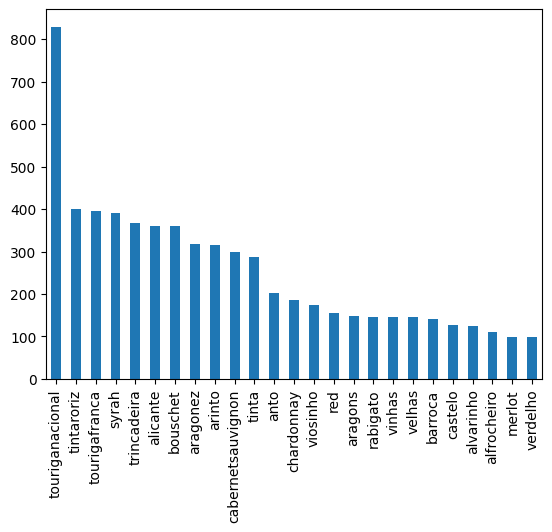

In [577]:
## a peak
data_df['variety'].value_counts()[0:25].plot.bar()

In [578]:
nan_value = float("NaN")
data_df.replace("", nan_value, inplace=True)
data_df.replace("None", nan_value, inplace=True)
data_df.dropna(subset=['variety'], inplace=True)
data_df.dropna(inplace=True)
#data_df.drop_duplicates(inplace=True)

In [579]:
data_df.reset_index(inplace=True)
data_df.drop(columns=['index'], inplace=True)

In [580]:
data_df.shape

(8936, 2)

In [581]:
documents = data_df.processed_text.to_list()
string_labels = data_df.variety.to_list()

le = preprocessing.LabelEncoder()
le.fit(data_df.variety)
data_df['cat_variety'] = le.transform(data_df.variety)

labels = data_df.cat_variety.to_list()

In [582]:
data_df.head()

,variety,processed_text,cat_variety
0,pinot grigio,"[my, favorite, white, wine, this, fantastic, w...",162
1,zinfandel,"[a, new, favorite, i, given, wine, delightful,...",241
2,zinfandel,"[bold, flavorful, aromatic, delicious, this, p...",241
3,moscato,"[yum, plus, environmentally, friendly, 4, 750m...",136
4,red blend,"[charles, charles, red, blend, this, smooth, r...",178


In [583]:
data_df.tail()

,variety,processed_text,cat_variety
8931,barroca,"[rubi, mdia, concentrao, aurola, tonalidade, a...",24
8932,arinto,"[plida, ligeiramente, esverdeada, nariz, sobre...",15
8933,touriganacional,"[rubi, intensa, muito, concentrada, centro, la...",216
8934,tourigafranca,"[rubi, intensa, muito, concentrada, centro, la...",215
8935,cabernetsauvignon,"[rubi, intensa, muito, concentrada, centro, la...",37


In [584]:
type(data_df.iloc[7042].processed_text)

list

In [585]:
type(data_df.iloc[300].processed_text)

list

In [586]:
type(data_df.iloc[-1].processed_text)

list

In [587]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(documents, labels, test_size=0.33)
target_names = varieties

In [588]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`

#train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
#valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, is_split_into_words=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, is_split_into_words=True)

In [589]:
class WineGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = WineGroupsDataset(train_encodings, train_labels)
valid_dataset = WineGroupsDataset(valid_encodings, valid_labels)

In [590]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))#.to("cuda")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /Users/kerry/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21"

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /Users/kerry/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequence

In [591]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [36]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [37]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [38]:
%%time

# train the model

trainer.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7081
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2658
Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy
200,5.154800,4.309846,0.118406
400,4.091800,3.878810,0.118406
600,3.823300,3.662431,0.099771
800,3.685900,3.507795,0.142775
1000,3.535000,3.452298,0.142775
1200,3.502100,3.434021,0.142489
1400,3.439300,3.427602,0.142775
1600,3.484800,3.403785,0.143922
1800,3.474200,3.401695,0.143349
2000,3.397400,3.384458,0.143349


***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num 

CPU times: user 1d 34min 34s, sys: 1h 25min 3s, total: 1d 1h 59min 38s
Wall time: 13h 32min 6s


TrainOutput(global_step=2658, training_loss=3.672814196262977, metrics={'train_runtime': 48726.733, 'train_samples_per_second': 0.436, 'train_steps_per_second': 0.055, 'total_flos': 2079096165481680.0, 'train_loss': 3.672814196262977, 'epoch': 3.0})

In [39]:
%%time
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3488
  Batch size = 20


CPU times: user 45min 49s, sys: 1min 13s, total: 47min 2s
Wall time: 23min 39s


{'eval_loss': 3.371943235397339,
 'eval_accuracy': 0.14420871559633028,
 'eval_runtime': 1419.7279,
 'eval_samples_per_second': 2.457,
 'eval_steps_per_second': 0.123,
 'epoch': 3.0}

In [40]:
# saving the fine tuned model & tokenizer
model_path = "models/wine-bert-base-cased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in wine-bert-base-uncased/config.json
Model weights saved in wine-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in wine-bert-base-uncased/tokenizer_config.json
Special tokens file saved in wine-bert-base-uncased/special_tokens_map.json


('wine-bert-base-uncased/tokenizer_config.json',
 'wine-bert-base-uncased/special_tokens_map.json',
 'wine-bert-base-uncased/vocab.txt',
 'wine-bert-base-uncased/added_tokens.json',
 'wine-bert-base-uncased/tokenizer.json')

In [44]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")#.to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {v: k for v, k in enumerate(data_df.variety)}
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [45]:
input1a = """I would like a type of wine that really wows. something perhaps to drink beside my best girlfriends on the beach somewhere. something that's new and exciting."""

In [46]:
get_prediction(input1a, convert_to_label=True)

'touriga'

In [47]:
input1b = """Eu gostaria de um tipo de vinho que realmente impressionasse. algo talvez para beber ao lado de minhas melhores amigas na praia em algum lugar. algo que é novo e excitante.""" 

In [48]:
get_prediction(input1b, convert_to_label=True)

'anto'

In [49]:
input2a = """
i want a red to go with my salmon. I like my salmon cooked medium and I like white wines normally but I hear reds are full of antioxidents.
"""

In [50]:
get_prediction(input2a, convert_to_label=True)

'alicante'

In [51]:
input2b = """
eu quero um vermelho para ir com o meu salmão. Eu gosto do meu salmão médio e gosto de vinhos brancos normalmente, mas ouvi dizer que os tintos são cheios de antioxidantes.
"""

In [52]:
get_prediction(input2b, convert_to_label=True)

'anto'

In [53]:
input3a = """
tickles the nose
"""

In [54]:
get_prediction(input3a, convert_to_label=True)

'alicante'

In [55]:
input3b = """
faz cócegas no nariz
"""

In [56]:
get_prediction(input3b, convert_to_label=True)

'anto'

In [57]:
input4a = """
I want the driest white wine available. the most dry you can think of. bone-dry.
"""

In [58]:
get_prediction(input4a, convert_to_label=True)

'alicante'

In [59]:
input4b = """
Quero o vinho branco mais seco disponível. o mais seco que você pode pensar. Osso seco.
"""

In [60]:
get_prediction(input4b, convert_to_label=True)

'anto'

In [61]:
input5a = """
I want a red. no wait I want a white. I think I want rose. on second thought, give me a bourbon. no, no. my favorite wine is a white. I'll do a white?
"""

In [62]:
get_prediction(input5a, convert_to_label=True)

'touriga'

In [63]:
input5a = """
Eu quero um vermelho. não espere, eu quero um branco. Acho que quero rosa. pensando bem, me dê um bourbon. não não. meu vinho favorito é um branco. Eu vou fazer um branco?
"""

In [64]:
get_prediction(input5a, convert_to_label=True)

'anto'

In [592]:
get_prediction("""seeking environmentally friendly wine""", convert_to_label=True)

'cabernet sauvignon'

In [67]:
data_df.variety.unique()

array(['cabernet', 'sauvignon', 'syrah', 'touriga', 'nacional',
       'alicante', 'bouschet', 'arinto', 'roupeiro', 'viognier',
       'encruzado', 'verdelho', 'aragonez', 'trincadeira', 'aragons',
       'outras', 'anto', 'viosinho', 'rabigato', 'gouveio', 'chardonnay',
       'alvarinho', 'tempranillo', 'callet', 'fogoneu', 'merlot', 'tinto',
       'tinta', 'barroca', 'roriz', 'franca', 'graciano', 'mazuelo',
       'rufete', 'manto', 'negro', 'ferno', 'pires', 'fino', 'menca',
       'malbec', 'alicate', 'castelo', 'caiada', 'pinot', 'noir',
       'loureiro', 'trajadura', 'alfrocheiro', 'jaen', 'tamarez',
       'malvasia', 'fina', 'vinhas', 'velhas', 'avesso', 'riesling',
       'blanc', 'tricadeira', 'garnacha', 'cariena', 'peluda',
       'periquita', 'moreto', 'perrum', 'bastardo', 'marufo', 'moscatel',
       'galego', 'branco', 'sercial', 'dourado', 'toro', 'cdega',
       'larinho', 'cbernet', 'franc', 'shiraz', 'baga', 'tannat', 'petit',
       'verdot', 'torronts', 'semi

In [ ]:
# needs improvement lol